# Lasagne Conv Net on Media Eval 2015 Placing Task - Locale

In [1]:
# Import Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import time
import cPickle as pickle

# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import own modules
import data_utils, visualize
import lasagne_model_predict_country as cnn_model

## Set hyperparameters and Load dataset

In [3]:
# Model hyperparameters
cnn_architecture = "complex_cnn"
num_filters = 32
filter_width = 3 # can be integer or tuple
pool_width = 2 
stride_width = 1 # can be integer or tuple
padding = 'full'  # can be integer or tuple or 'full', 'same', 'valid'
hidden_size = 256 # size of hidden layer of neurons
dropout_p = 0.5
# lr_decay = 0.995
reg_strength = 0
# grad_clip = 10

# Optimization hyperparams
# LEARNING_RATE = 1e-2
LEARNING_RATE = 0.045

USE_OPTIMIZER = "nesterov_momentum"
# USE_OPTIMIZER = "adam"
# (1) Nesterov Momentum
MOMENTUM = 0.9
# (2) Adam
beta1=0.9
beta2=0.999
epsilon=1e-08
# Optimizer config
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

# Training parameters
batchsize = 500
num_epochs = 20
record_per_iter = True  # save train and val loss/accuracy after each batch runthrough

In [4]:
# Load Data Set

# DATA_BATCH = '000_small_'
# DATA_SIZE = '48by32'
# DATA_SET = DATA_BATCH + DATA_SIZE
# NUM_CLASSES = 5

DATA_SET = 'subset_48by32_5'
NUM_CLASSES = 5
NUM_BATCHES = 6
USE_BATCH = 0

print ('Data Set:', DATA_SET)
print ('Num classes:', NUM_CLASSES)
print ('Batches: {}'.format(USE_BATCH))
print ('Preparing Data Set....')

X_input_filename = 'data_maps/' + DATA_SET + '/x_input_' + str(USE_BATCH) + '.npy'
Y_output_filename = 'data_maps/' + DATA_SET + '/y_labels_' + str(USE_BATCH) + '.npy'

X = data_utils.load_npy_file(X_input_filename)
Y = data_utils.load_npy_file(Y_output_filename)
# print 'X: {}'.format(X.shape)
# print 'Y: {}'.format(Y.shape)
# print 'Y sample ', Y[:10]

num_samples, H, W, C = X.shape

# swap C and H axes --> expected input
X = np.swapaxes(X, 1, 3)  # (num_samples, C, W, H)
X -= np.mean(X, axis = 0)  # Data Preprocessing: mean subtraction
X /= np.std(X, axis = 0)  # Normalization

#Splitting into train, val, test sets

num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# print 'num_train: %d, num_val: %d, num_test: %d' % (num_train, num_val, num_test)

X_train = X[:num_train]
X_val = X[num_train:num_train+num_val]
X_test = X[num_train+num_val:]

y_train = Y[:num_train]
y_val = Y[num_train:num_train+num_val]
y_test = Y[num_train+num_val:]

print ('X_train', X_train.shape)
print ('y_train', y_train.shape)
print ('X_val', X_val.shape)
print ('y_val', y_val.shape)
print ('X_test', X_test.shape)
print ('y_test', y_test.shape)


('Data Set:', 'subset_48by32_5')
('Num classes:', 5)
Batches: 0
Preparing Data Set....
('X_train', (24000, 3, 48, 32))
('y_train', (24000,))
('X_val', (3000, 3, 48, 32))
('y_val', (3000,))
('X_test', (3000, 3, 48, 32))
('y_test', (3000,))


## Build network and train

In [5]:
# Create model and compile train and val functions
train_fn, val_fn, pred_fn, l_out = cnn_model.main_create_model(C, W, H, NUM_CLASSES, cnn_architecture=cnn_architecture, num_filters=num_filters, filter_width=filter_width, pool_width=pool_width, stride=stride_width, pad=padding, hidden_size=hidden_size, dropout=dropout_p, use_optimizer=USE_OPTIMIZER, learning_rate=LEARNING_RATE, momentum=MOMENTUM, beta1=beta1, beta2=beta2, epsilon=epsilon)

Building network...
Building a complex CNN...
Compiling functions...
Using Update: nesterov_momentum
Compiling Finished!


In [16]:
# Train the model. Save results in file
timestr = time.strftime("%Y%m%d-%H%M%S")
save_results_to_file = 'results/{}_batch_{}_{}_ep{}_num_train{}_{}.txt'.format(DATA_SET, str(USE_BATCH), USE_OPTIMIZER, num_epochs, num_train, timestr)

train_err_list, train_acc_list, val_err_list, val_acc_list, epochs_train_err_list, epochs_train_acc_list, epochs_val_err_list, epochs_val_acc_list = cnn_model.train(num_epochs, batchsize, num_train, num_val, USE_OPTIMIZER, train_fn, val_fn, X_train, y_train, X_val, y_val, record_per_iter=record_per_iter, save_results_to_file=save_results_to_file)

Training on: 20 epochs of batch size 500 with num training samples 24000
Using optimizer: nesterov_momentum
Validation Size: 3000
Starting training...
Ep 0 	iter 0  	loss 1.62056, train acc 23.40, val acc 24.80
Ep 0 	iter 1  	loss 1.61227, train acc 23.60, val acc 25.20
Epoch 1 of 20 took 62.402s
  training loss:		1.616414
  training accuracy:		23.50 %
  validation loss:		1.601183
  validation accuracy:		25.20 %
Training finished!
Saving training results to file...
Saving results to file finished!


## Test and Plot

In [17]:
# Testing.
print('Testing...')
test_err = 0
test_acc = 0
test_batches = 0

for batch in data_utils.iterate_minibatches(X_test, y_test, batchsize, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
    
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Testing...
Final results:
  test loss:			1.602910
  test accuracy:		23.47 %


In [34]:
# Sample
predictions = pred_fn(X_test)

correct_set = set()
wrong_set = set()

NUM_SAMPLES = 10

for index, sample in enumerate(predictions):
    predicted_class = np.argmax(sample)
    correct_class = y_test[index]
#     print 'predicted', predicted_class
#     print 'correct', correct_class
    if predicted_class == correct_class:
        correct_set.add((index, predicted_class, correct_class))
        print 'num correct predictions', len(correct_set)
    else:
        wrong_set.add((index, predicted_class, correct_class))

    if len(correct_set) >= NUM_SAMPLES and len(wrong_set) >= NUM_SAMPLES:
        break
        
        
map_row_imagename = pickle.load( open ('data_maps/subset_48by32_5/map_row_imagename_0.pickle', 'rb') )
map_country_class = pickle.load( open ('data_maps/subset_48by32_5/country_name_class_index_map.pickle', 'rb') )
map_class_country = {v:k for k,v in map_country_class.items()}

print("**********")
print("Correct Set!")
for index_in_train, predicted_class, correct_class in correct_set:
    row_num = num_train + num_val + index_in_train
    print row_num
    print map_row_imagename[row_num]
    print 'Predicted: ', map_class_country[predicted_class], 'Correct: ', map_class_country[correct_class]
    
print("**********")
print("Wrong Set!")
for index_in_train, predicted_class, correct_class in wrong_set:
    row_num = num_train + num_val + index_in_train
    print row_num
    print map_row_imagename[row_num]
    print 'Predicted: ', map_class_country[predicted_class], 'Correct: ', map_class_country[correct_class]


num correct predictions 1
num correct predictions 2
num correct predictions 3
num correct predictions 4
num correct predictions 5
num correct predictions 6
num correct predictions 7
num correct predictions 8
num correct predictions 9
num correct predictions 10
**********
Correct Set!
27023
e2126994144bcea81237148571bbb429
Predicted:  Spain Correct:  Spain
27008
e211426d535f3e645bdce7913f47789f
Predicted:  Italy Correct:  Italy
27043
e213a9116eb33dd597a26cefc4cf50
Predicted:  Italy Correct:  Italy
27032
e21341b1b85983e9d22e4624ac8291c7
Predicted:  Canada Correct:  Canada
27044
e213aaf39ae237ba40395aeae2e62ae8
Predicted:  Spain Correct:  Spain
27031
e212fcd9c6a2bb5a3860856ac5e6d8
Predicted:  Italy Correct:  Italy
27026
e21282d67babdfc382e29299b9fca12
Predicted:  Spain Correct:  Spain
27033
e21342ace2a31841952770376dbf4b
Predicted:  France Correct:  France
27005
e210f6905aa2d4631c9850f0a5e435c
Predicted:  Italy Correct:  Italy
27038
e2138364fdc188c3b24eb09da6425236
Predicted:  Spain Corre

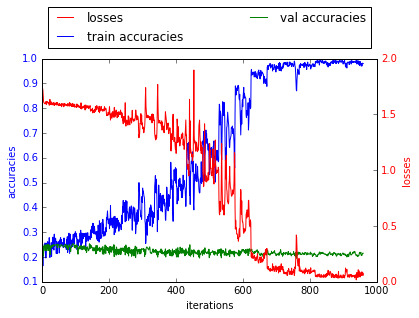

In [30]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = X_train.shape[0]
if record_per_iter:
    xlabel = "iterations"
else:
    xlabel = "epochs"
# Printing training losses and training + validation accuracies
data_set_name = DATA_SET + 'batch_' + str(USE_BATCH) + '_' + USE_OPTIMIZER
visualize.plot_loss_acc(data_set_name, train_err_list, train_acc_list, val_acc_list, LEARNING_RATE, reg_strength, num_epochs, num_train, xlabel=xlabel)

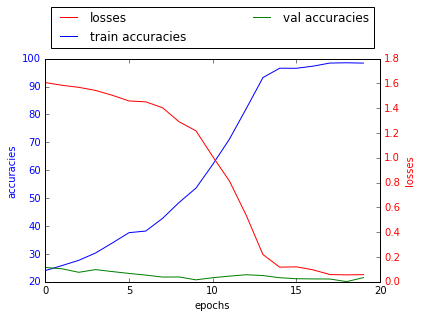

In [31]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = X_train.shape[0]
xlabel = "epochs"
# Printing training losses and training + validation accuracies
data_set_name = DATA_SET + 'batch_' + str(USE_BATCH) + '_on_epochs' + '_' + USE_OPTIMIZER
visualize.plot_loss_acc(data_set_name, epochs_train_err_list, epochs_train_acc_list, epochs_val_acc_list, LEARNING_RATE, reg_strength, num_epochs, num_train, xlabel=xlabel)


## Save network weights

In [32]:
# Store params
model_filename = 'model_weights/' + DATA_SET + 'batch_' + str(USE_BATCH) + '_' + USE_OPTIMIZER + '.npz'
np.savez(model_filename, lasagne.layers.get_all_param_values(l_out))

# To load
# with np.load(model_filename) as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)

## Save Acc / Err Lists

In [33]:
pickle_filename = 'loss_acc_values/' + DATA_SET + 'batch_' + str(USE_BATCH) + '_' + USE_OPTIMIZER + '.pickle'
pickle.dump( (train_err_list, train_acc_list, val_err_list, val_acc_list), open(pickle_filename, 'wb') )